In [1]:
import pandas as pd
import utilssphering
import itertools
import pycytominer
import os

In [ ]:
# Load checkpoints

df_replicating = pd.read_csv("checkpoints/moa-replicating-sphering.csv", converters={'Null_Replicating':utilssphering.safe_literal_eval, "Replicating":utilssphering.safe_literal_eval)
df_matching = pd.read_csv("checkpoints/moa-matching-sphering.csv", converters={'Null_Matching':utilssphering.safe_literal_eval, "Matching":utilssphering.safe_literal_eval)

# For some reason, adding cell counts makes the above evals fail with an "SyntaxError: unexpected EOF while parsing"
# df_replicating = pd.read_csv("checkpoints/moa-replicating-sphering.csv")
# df_matching = pd.read_csv("checkpoints/moa-matching-sphering.csv")

In [4]:
### Creating dropout datasets + matrix

def return_prop95(dataframe, match_or_rep="replicating", enable_sphering=False):
    """
    dataframe: pandas.DataFrame to find the prop95 for 
    """
    n_samples = 10000
    n_replicates = 4  #number of sample replicates within each plate 
    metadata_common = 'Metadata_moa'
    # metadata_perturbation = 'Metadata_broad_sample'
    # group_by_feature = 'Metadata_broad_sample'
    metadata_perturbation = 'Metadata_broad_sample'
    group_by_feature = 'Metadata_pert_iname'
    if match_or_rep.casefold() == "replicating":
        if enable_sphering:
            _, _, prop_95_replicating_sphere, _ = utilssphering.calculate_percent_replicating_MOA("", "", data_df=dataframe)
            return prop_95_replicating_sphere

        if not enable_sphering: 
            plate_df = utils.remove_negcon_empty_wells(dataframe)
            replicate_corr = list(utils.corr_between_replicates(plate_df, group_by_feature))
            null_replicating = list(utils.corr_between_non_replicates(plate_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name=group_by_feature))
            prop_95_replicating, _ = utils.percent_score(null_replicating, replicate_corr, how='right')
            return prop_95_replicating

    if match_or_rep.casefold() == "matching":
        if enable_sphering:
            _, _, prop_95_matching_sphere, _ = utilssphering.calculate_percent_matching_MOA("", "", data_df=dataframe)
            print(f"prop_95_matching_sphere: {prop_95_matching_sphere}")
            return prop_95_matching_sphere

        if not enable_sphering:
            plate_df = utils.remove_negcon_empty_wells(dataframe)
            matching_corr = list(utils.corr_between_perturbation_pairs(plate_df, 'Metadata_moa', 'Metadata_broad_sample'))
            null_matching = list(utils.corr_between_perturbation_non_pairs(plate_df, n_samples=n_samples, metadata_common=metadata_common, metadata_perturbation=metadata_perturbation))
            prop_95_matching, _ = utils.percent_score(null_matching, matching_corr, how='right')
            return prop_95_matching


def do_feature_select(plate_df):
    """
    Find the column names that are CellProfiler features. Eg. column names
    that start with "Nuclei" or "Cytoplasm"
    """
    # feature_select_features = pycytominer.cyto_utils.infer_cp_features(
    #     plate_df
    # )
    # For all of the cellprofiler features, perform these operations on them
    return pycytominer.feature_select(
        profiles=plate_df,
        # features=feature_select_features,
        # operation=['variance_threshold','correlation_threshold',
        # 'drop_na_columns','blocklist']
    )

def all_combo_dropouts_in_a_category(category_list,outfile,subsample=None):
    """
    Create a database with dropped out features

    category_list: the categories to drop out (for example, Nuclei, Cytoplasm, Cells)
    outfile: save csv path
    """
    # For all of the categories, find all possible combinations with itertools.combinations
    to_try = [y for x in range(len(category_list)+1) for y in list(set(itertools.combinations(category_list,x)))]

    # If the output csv already exists, check what dropouts have already been tried
    # Don't try them again
    if os.path.exists(outfile):
        dropout_df = pd.read_csv(outfile)
        tried=list(dropout_df['Dropout'])
        print(f"Already try {tried},skipping")
        to_try = [x for x in to_try if str(x) not in tried]
    # Otherwise, dropout columns will be generated from scratch
    else:
        dropout_df = pd.DataFrame()
    
    # For the given categories, go through each combination (eg. ('Cells', 'Cytoplasm'), ('Nuclei', 'Cytoplasm') etc.)
    for eachdropout in to_try:
        # Get what columns are expected. I don't like this method
        normalized_master = pd.read_csv('../profiles-pilots/profiles/Stain5_CondC_Standard/BR00120274/BR00120274_normalized_negcon.csv.gz')
        col_list = normalized_master.columns
        if subsample:
             for each_item in subsample:
                metadata_list = [x for x in col_list if 'Metadata' in x] 
                col_list = metadata_list+[x for x in col_list if each_item in x]
        for each_item in eachdropout:
            # Create a list of columns that DOESN'T contain the categories being iterated
            # Thus this will iterate over all categories (eg. nuclei, cell, cytoplasm) and
            # drop all of the column names
            col_list = [x for x in col_list if each_item not in x]
        dropout_dict = {}
        temp_dropout_dict = {}
        # Code unique to this dataset. Iterate through plates
        for eachplate in range(70,78):
            try:
                # Read only the columns previously defined for each plate being iterated over
                # Again, don't like this hardcoding. Should be some sort of os.walk situation
                normalized = pandas.read_csv(
                    f'../profiles-pilots/profiles/Stain5_CondC_Standard/BR001202{eachplate}/BR001202{eachplate}_normalized_negcon.csv.gz',
                    usecols=col_list)
                # For the loaded dataset, calculate feature selection AFTER column dropout
                feature_select = do_feature_select(normalized)
                temp_dropout_dict[f'{eachplate}_featnum']=len(feature_select.columns)
                # Now, calculate the perc_rep for the dropout dataset 
                ### NOTE: in utilsphering, calculate_percent_replicating_MOA has been updated to return
                ### replicate_corr, null_corr, prop_95, value_95_replicating
                ### In this example, calculate_percent_replicating_MOA is **only returning prop_95**
                dropout_dict[f'BR001202{eachplate}']= calculate_percent_replicating_MOA('','',data_df=feature_select)
            except:
                dropout_dict[f'BR001202{eachplate}']=0
        # Convert the calculated perc_rep into np.array for each dropout 
        results_array = np.array(list(dropout_dict.values()))
        for k,v in temp_dropout_dict.items():
            dropout_dict[k]=v
        # For the dropout dataset created, calculate the mean perc_replicating for ALL of the plates
        # Why all of the plates? Are these replicates?
        # Means are calculated within each dropout group
        dropout_dict['Mean']=results_array.mean()
        dropout_dict['Median']=np.median(results_array)
        dropout_dict['Standard deviation']=np.std(results_array)
        dropout_dict['Dropout']=eachdropout
        dropout_dict['Remaining'] = [x for x in category_list if x not in eachdropout]
        dropout_dict['n_columns']=len(col_list)
        dropout_df = dropout_df.append(dropout_dict,ignore_index=True)
        print(eachdropout,dropout_dict['Mean'])
        dropout_df.to_csv(outfile,index=False)
    print(dropout_df['Mean'].describe())
    print(dropout_df['Median'].describe())

def category_dropout(
    experiment_metadata,
    profile_parent_dir, 
    category_list, 
    match_or_rep_or_both="replicating",
    enable_sphering="both", 
    outfile=None
):
    rep_df_list = list()
    match_df_list = list()

    # Check if dropout has previously been performed
    # if os.path.exists(outfile):
    #     # Limitation of this implementation:
    #     # If you switch from sphering to not sphering, this will fail to 
    #     # run the analysis without sphering as it only checks the 'dropout'
    #     # column combinations and not any other column (such as if sphering was T/F).
    #     dropout_df = pd.read_csv(outfile)
    #     rep_df_list.append(dropout_df)
    #     match_df_list.append(dropout_df)
    #     tried=list(dropout_df["dropout"])
    #     print(f"Already tried {tried}. Skipping.")
    #     possible_combinations = [x for x in possible_combinations if str(x) not in tried]
    #     # Otherwise, dropout columns will be generated from scratch

    for ind, row in experiment_metadata.iterrows():
        for root, dirs, files in os.walk(profile_parent_dir):
            load_path = os.path.join(profile_parent_dir, row["Batch"], row["Assay_Plate_Barcode"],  row["Assay_Plate_Barcode"]+"_normalized_negcon.csv.gz")
            for file in files:
                if os.path.join(root, file) == load_path:
                    load_df = pd.read_csv(load_path)
                    input_columns = load_df.columns
                    possible_combinations = [y for x in range(len(category_list)+1) for y in list(set(itertools.combinations(category_list,x)))]
                    if len(possible_combinations) == 0:
                        # Either no combinations available or they're already present in the outfile
                        print("All combinations already computed")
                        return
                    # Iterate through the combination to dropout
                    for dropout_group in possible_combinations: 
                        col_list = input_columns
                        # Within the droupout group, find the column to actually drop
                        for each_item in dropout_group:
                            # Only keep columns that don't contain the dropout
                            col_list = [x for x in col_list if each_item not in x]
                        print(f"---- Dropping: {dropout_group} ----")
                        try:
                            dropped_dataframe = pd.DataFrame(load_df[col_list])
                            feature_select = do_feature_select(dropped_dataframe)
                        except Exception as e:
                            print(e)
                            feature_select = 0
                        # return feature_select
                        if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
                            if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                                try:
                                    # Added to tackle an issue where longer dropout runs would error out due to NaN input
                                    # Unsure of the source of the NaN input. This is a temporary solution.
                                    prop_95 = return_prop95(feature_select, match_or_rep="replicating", enable_sphering=True)
                                except:
                                    prop_95 = 0
                                _df = pd.DataFrame({
                                    "Batch": row["Batch"],
                                    "Assay_Plate_Barcode": row["Assay_Plate_Barcode"],
                                    "num_features": len(feature_select.columns),
                                    "dropout": str(dropout_group),
                                    "n_columns": len(col_list),
                                    "sphering": True,
                                    "percent_replicating": [prop_95]
                                })
                                rep_df_list.append(_df)
                            if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both":
                                try:
                                    prop_95 = return_prop95(feature_select, match_or_rep="replicating", enable_sphering=False)
                                except:
                                    prop_95 = 0                
                                _df = pd.DataFrame({
                                    "Batch": row["Batch"],
                                    "Assay_Plate_Barcode": row["Assay_Plate_Barcode"],
                                    "num_features": len(feature_select.columns),
                                    "dropout": str(dropout_group),
                                    "n_columns": len(col_list),
                                    "sphering": False,
                                    "percent_replicating": [prop_95]
                                })
                                rep_df_list.append(_df)
                        if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
                            if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                                try:
                                    prop_95 = return_prop95(feature_select, match_or_rep="matching", enable_sphering=True)
                                except:
                                    prop_95 = 0
                                _df = pd.DataFrame({
                                    "Batch": row["Batch"],
                                    "Assay_Plate_Barcode": row["Assay_Plate_Barcode"],
                                    "num_features": len(feature_select.columns),
                                    "dropout": str(dropout_group),
                                    "n_columns": len(col_list),
                                    "sphering": True,
                                    "percent_matching": [prop_95]
                                })
                                match_df_list.append(_df)
                            if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both":
                                try:
                                    prop_95 = return_prop95(feature_select, match_or_rep="matching", enable_sphering=False)
                                except:
                                    prop_95 = 0
                                _df = pd.DataFrame({
                                    "Batch": row["Batch"],
                                    "Assay_Plate_Barcode": row["Assay_Plate_Barcode"],
                                    "num_features": len(feature_select.columns),
                                    "dropout": str(dropout_group),
                                    "n_columns": len(col_list),
                                    "sphering": False,
                                    "percent_matching": [prop_95],
                                })
                                match_df_list.append(_df)
            
        # Concatenate the data
        if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
            rep_df = pd.concat(rep_df_list, ignore_index=True)
        if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
            match_df = pd.concat(match_df_list, ignore_index=True)
                    
        # Merge so perc rep and match is in the same place
        if match_or_rep_or_both.casefold() == "both":
            merged_df = rep_df.merge(match_df, how="inner")
            if outfile is not None:
                merged_df.to_csv(outfile,index=False)
            return merged_df
        if match_or_rep_or_both.casefold() == "replicating":
            if outfile is not None:
                rep_df.to_csv(outfile,index=False)
            return rep_df
        if match_or_rep_or_both.casefold() == "matching":
            if outfile is not None:
                match_df.to_csv(outfile,index=False)
            return match_df
        
# TODO: Check that this is accurately dropping, integrate with os.walk, integrate with heatmap matrix
# No need to integrate with os.walk. Use metadata csv


# 1. Feed experiment_metadata
# 2. Finds normalized negcon file, performs feature select


experiment_metadata = pd.read_csv("output/all-profile-metadata.csv")
profile_parent_dir = "../jump-scope/profiles"

drops = category_dropout(experiment_metadata.loc[:2,:], profile_parent_dir, ["RNA"], "both", "yes", "test.csv")
drops
# ['Nuclei','Cells','Cytoplasm']


---- Dropping: () ----
prop_95_matching_sphere: 23.25581395348837
---- Dropping: ('RNA',) ----
prop_95_matching_sphere: 23.25581395348837


,Batch,Assay_Plate_Barcode,num_features,dropout,n_columns,sphering,percent_replicating,percent_matching
0,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,4287,(),4355,True,58.888889,23.255814
1,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,3535,"('RNA',)",3590,True,60.000000,23.255814


In [31]:

def do_feature_select(plate_df):
    """
    Find the column names that are CellProfiler features. Eg. column names
    that start with "Nuclei" or "Cytoplasm"
    """
    feature_select_features = pycytominer.cyto_utils.infer_cp_features(
        plate_df
    )
    # For all of the cellprofiler features, perform these operations on them
    return pycytominer.feature_select(
        profiles=plate_df,
        features=feature_select_features,
        operation=['variance_threshold','correlation_threshold',
        'drop_na_columns','blocklist']
    )

def create_moa_dataframe(experiment_metadata, profile_parent_dir, batch_col="Batch", match_or_rep_or_both="replicating", enable_sphering="both", dropout_cols=None):
    """
    batch_col is the name of the column to distinguish the profile parent folder. Eg. "Scope1_MolDev_10X" or "1siteSubSample_Scope1_MolDev_10X"
    Output df will also use this batch_col name
    """
    n_samples = 10000
    n_replicates = 4  # number of sample replicates within each plate 
    metadata_common = 'Metadata_moa'
    metadata_perturbation = 'Metadata_broad_sample'
    group_by_feature = 'Metadata_pert_iname'

    corr_replicating_list = list()
    corr_matching_list = list()
    passed_data = list()

    for ind, a_vendor in enumerate(experiment_metadata["Vendor"].unique()):
        print(f"Processing {a_vendor}")
        vendor_data = experiment_metadata.loc[experiment_metadata["Vendor"] == a_vendor]
        for a_batch in vendor_data[batch_col].unique():
            batch_data = vendor_data.loc[vendor_data[batch_col] == a_batch]
            for a_plate in batch_data["Assay_Plate_Barcode"].unique():
                # plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
                data_path = os.path.join(profile_parent_dir, a_batch, a_plate, a_plate+"_normalized_negcon.csv.gz")
                load_data = pd.read_csv(data_path)
                if dropout_cols is not None:
                    input_columns = load_data.columns
                    possible_combinations = [y for x in range(len(dropout_cols)+1) for y in list(set(itertools.combinations(dropout_cols,x)))]
                    if len(possible_combinations) == 0:
                        # Either no combinations available or they're already present in the outfile
                        print("All combinations already computed")
                        return
                    # Iterate through the combination to dropout
                    for dropout_group in possible_combinations: 
                        col_list = input_columns
                        # Within the droupout group, find the column to actually drop
                        for each_item in dropout_group:
                            # Only keep columns that don't contain the dropout
                            col_list = [x for x in col_list if each_item not in x]
                        print(f"---- Dropping: {dropout_group} ----")
                        try:
                            dropped_df = pd.DataFrame(load_data[col_list])
                            feature_selected_df = do_feature_select(dropped_df)
                        except Exception as e:
                            print(f"Error: {e}")
                            feature_select = 0
                        print(data_path)
                        try:
                            if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
                                if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                                    sphere_bool = True
                                    replicate_corr_sphere, null_replicating_sphere, prop_95_replicating_sphere, value_95_replicating_sphere = utilssphering.calculate_percent_replicating_MOA("", "", data_df=feature_selected_df)
                                    corr_replicating_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                                batch_col: a_batch,
                                                                                'Assay_Plate_Barcode': a_plate,
                                                                                "num_features": len(feature_selected_df.columns),
                                                                                "dropout": str(dropout_group),
                                                                                "n_columns": len(col_list),
                                                                                'Replicating':[replicate_corr_sphere],
                                                                                'Null_Replicating':[null_replicating_sphere],
                                                                                'Percent_Replicating':prop_95_replicating_sphere,
                                                                                'Value_95':value_95_replicating_sphere,
                                                                                'sphering': sphere_bool}, index=[ind]))

                                if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both": 
                                    sphere_bool = False
                                    plate_df = utils.remove_negcon_empty_wells(feature_selected_df)
                                    replicate_corr = list(utils.corr_between_replicates(plate_df, group_by_feature))
                                    null_replicating = list(utils.corr_between_non_replicates(plate_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name=group_by_feature))
                                    prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating, replicate_corr, how='right')
                                    corr_replicating_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                                batch_col: a_batch,
                                                                                'Assay_Plate_Barcode': a_plate,
                                                                                'Replicating':[replicate_corr],
                                                                                'Null_Replicating':[null_replicating],
                                                                                'Percent_Replicating':prop_95_replicating,
                                                                                'Value_95':value_95_replicating,
                                                                                'sphering': sphere_bool}, index=[ind]))

                            if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
                                if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                                    sphere_bool = True
                                    matching_corr_sphere, null_matching_sphere, prop_95_matching_sphere, value_95_matching_sphere = utilssphering.calculate_percent_matching_MOA("", "", data_df=feature_selected_df)
                                    corr_matching_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                            batch_col: a_batch,
                                                                            'Assay_Plate_Barcode': a_plate,
                                                                            'Matching':[matching_corr_sphere],
                                                                            'Null_Matching':[null_matching_sphere],
                                                                            'Percent_Matching':prop_95_matching_sphere,
                                                                            'Value_95':value_95_matching_sphere,
                                                                            'sphering': sphere_bool}, index=[ind]))
                                
                                if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both": 
                                    sphere_bool = False
                                    plate_df = utils.remove_negcon_empty_wells(feature_selected_df)
                                    matching_corr = list(utils.corr_between_perturbation_pairs(plate_df, 'Metadata_moa', 'Metadata_broad_sample'))
                                    null_matching = list(utils.corr_between_perturbation_non_pairs(plate_df, n_samples=n_samples, metadata_common=metadata_common, metadata_perturbation=metadata_perturbation))
                                    prop_95_matching, value_95_matching = utils.percent_score(null_matching, matching_corr, how='right')
                                    corr_matching_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                            batch_col: a_batch,
                                                                            'Assay_Plate_Barcode': a_plate,
                                                                            'Matching':[matching_corr],
                                                                            'Null_Matching':[null_matching],
                                                                            'Percent_Matching':prop_95_matching,
                                                                            'Value_95':value_95_matching,
                                                                            'sphering': sphere_bool}, index=[ind]))
                        except Exception as e:
                            logging.error(f"Passed: {data_path}", exc_info=e)
    # Concatenate the data
    if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
        corr_replicating_df = pd.concat(corr_replicating_list, ignore_index=True)
    if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
        corr_matching_df = pd.concat(corr_matching_list, ignore_index=True)
                
    # Merge metadata with output dataframes
    merge_columns = ['Vendor', batch_col, 'Assay_Plate_Barcode']
    if match_or_rep_or_both.casefold() == "both":
        corr_replicating_df = experiment_metadata.merge(corr_replicating_df, how="inner", on=merge_columns)
        corr_matching_df = experiment_metadata.merge(corr_matching_df, how="inner", on=merge_columns)
        return corr_replicating_df, corr_matching_df
    if match_or_rep_or_both.casefold() == "replicating":
        return experiment_metadata.merge(corr_replicating_df, how="inner", on=merge_columns)
    elif match_or_rep_or_both.casefold() == "matching":
        return experiment_metadata.merge(corr_matching_df, how="inner", on=merge_columns)


experiment_metadata = pd.read_csv("output/all-profile-metadata.csv")
profile_parent_dir = "../jump-scope/profiles"
# experiment_metadata = experiment_metadata[(experiment_metadata["Assay_Plate_Barcode"] == "BRO0117059_20X") & (~experiment_metadata["Batch"].str.contains("siteSub"))]

df = create_moa_dataframe(experiment_metadata, "../jump-scope/profiles", match_or_rep_or_both="both", enable_sphering="yes", dropout_cols=['RNA'])
df

Processing Yokogawa_US
---- Dropping: () ----
../jump-scope/profiles/Scope1_Yokogawa_US_20X_6Ch_BRO0117059/BRO0117059_20X/BRO0117059_20X_normalized_negcon.csv.gz
---- Dropping: ('RNA',) ----
../jump-scope/profiles/Scope1_Yokogawa_US_20X_6Ch_BRO0117059/BRO0117059_20X/BRO0117059_20X_normalized_negcon.csv.gz


(        Vendor                                  Batch  \
 0  Yokogawa_US  Scope1_Yokogawa_US_20X_6Ch_BRO0117059   
 1  Yokogawa_US  Scope1_Yokogawa_US_20X_6Ch_BRO0117059   
 
                Plate_Map_Name Assay_Plate_Barcode  Modality  Images_per_well  \
 0  JUMP-MOA_compound_platemap      BRO0117059_20X  Confocal                9   
 1  JUMP-MOA_compound_platemap      BRO0117059_20X  Confocal                9   
 
    Sites-SubSampled  Binning  Magnification  Number_of_channels  ...  \
 0               NaN        1             20                   6  ...   
 1               NaN        1             20                   6  ...   
 
     Size_MB Size_MB_std num_features   dropout n_columns  \
 0  7.954439    0.000583          467        ()      4267   
 1  7.954439    0.000583          421  ('RNA',)      3532   
 
                                          Replicating  \
 0  [0.20376962714650543, 0.46971569908024957, 0.8...   
 1  [0.20431095810594152, 0.45765328128940497, 0.8...   
 


In [ ]:
# Gather the dropout data
df_list = list()
t = pd.DataFrame()
_, parent_folders, _ = next(os.walk("../jump-scope/profiles/"))
for batch_name in parent_folders:
    _, subdirs, _ = next(os.walk(f"../jump-scope/profiles/{batch_name}"))
    for plate_barcode in subdirs:
        batch_path = f"../jump-scope/profiles/{batch_name}/{plate_barcode}"
        for _, _, files in os.walk(batch_path):
            for filename in files:
                if filename.endswith("-dropout.csv"):
                    dropout_path = f"{batch_path}/{plate_barcode}-dropout.csv"
                    dropout_df = pd.read_csv(dropout_path)
                    dropout_df["batch_name"] = batch_name
                    df_list.append(dropout_df)

collated_dropout_df = pd.concat(df_list)
collated_dropout_df.to_csv("checkpoints/feature-dropouts-nuclei_cytoplasm_cells.csv")

In [ ]:
def create_and_graph_heatmap(df,col_list,row_list,cmap,title,figsize,xbreaklen=120,ybreaklen=180,xkcd=False):
    full_col_list = []
    full_col_list_for_labels = []
    full_row_list= []
    full_row_list_for_labels = []
    for eachlen in range(len(col_list)+1):
        full_col_list += sorted([str(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
        full_col_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
    for eachlen in range(len(row_list)+1):
        full_row_list += sorted([str(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
        full_row_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
    square=pd.DataFrame(columns=full_col_list,index=full_row_list)
    for _,row in df.iterrows():
        sub_rows=[]
        sub_cols=[]
        for thing in row['dropout']:
            if thing not in col_list:
                sub_cols.append(thing)
            else:
                sub_rows.append(thing)
        sub_rows.sort()
        sub_cols.sort()
        # square[str(sub_cols)][str(sub_rows)]=row['percent_replicating']*100
        square.loc[str(sub_cols),str(sub_rows)] = row["percent_replicating"]
    square=square.fillna(0)
    fig, ax = plt.subplots(figsize=figsize)
    fig.set_facecolor("white")
    # if xkcd:
    #     cmap=sns.light_palette(cmap,input='xkcd',as_cmap=True)
    g=sns.heatmap(square,cmap=cmap,annot=True)
    xlabels=['None']
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    for label in full_col_list_for_labels[1:]:
        xlabels.append(textwrap.fill(label, width=xbreaklen/len(full_col_list_for_labels),break_long_words=False))
    g.set_xticklabels(xlabels, rotation=0)
    ylabels=['None']
    for label in full_row_list_for_labels[1:]:
        ylabels.append(textwrap.fill(label, width=ybreaklen/len(full_row_list_for_labels),break_long_words=False))
    g.set_yticklabels(ylabels, rotation=0)
    g.set_title(title)
    # plt.savefig(f'figures/{title}.png',dpi=300)
    
    
create_and_graph_heatmap(
    dropout_df,
    col_list=['Nuclei','Cytoplasm'],
    row_list=['Cells'],
    cmap='BuPu',
    title = 'Mean Percent Replicating by Compartments Present for ALL profiles',
    figsize=(10,6))


In [ ]:
# Dropout groups
# Basically, make matrix plots for profile groups
# ie. compare dropouts for the same batch that have different site subsamples

subsample_df = pd.read_csv('output/FoV-experiment-metadata.tsv', sep='\t')

dropout_df = pd.read_csv(
    "checkpoints/feature-dropouts-nuclei_cytoplasm_cells.csv", 
    converters={'dropout':ast.literal_eval}
)
dropout_df


In [ ]:
# Create a new DF that combines the dropout results with the subsample info

batch_list = list(set(dropout_df.loc[:,"batch_name"]))
plate_list = list(set(dropout_df.loc[:, "assay_plate_barcode"]))
for plate in plate_list:
    if plate == "BRO0117033_20xb":
    # print(plate)
        t = dropout_df.loc[dropout_df["assay_plate_barcode"] == plate]
        for subset in set(t["batch_name"]):
            subset_df = t[t["batch_name"] == subset]
            create_and_graph_heatmap(
                subset_df,
                col_list=['Nuclei','Cytoplasm'],
                row_list=['Cells'],
                cmap='BuPu',
                title = f"Percent replicating for {subset}",
                figsize=(10,6))



In [ ]:
# Alt 

def create_and_graph_heatmap(df,col_list,row_list,ax_=None,xbreaklen=120,ybreaklen=180):
    full_col_list = []
    full_col_list_for_labels = []
    full_row_list= []
    full_row_list_for_labels = []
    for eachlen in range(len(col_list)+1):
        # This works out all of the combinations for the given col list (eg. nuclei, nuclei+cells...)
        # Each combination is sorted so the label order is consistent, then the whole list itself is sorted
        # itertools.combinations will only return combinations that are equal in length to each len,
        # thus only combination lengths of 1 and 2 will be returned for col_list=["Nuclei", "Cells"]
        full_col_list += sorted([str(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
        # This generates the actual labels for above, ready to be displayed
        full_col_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
    for eachlen in range(len(row_list)+1):
        full_row_list += sorted([str(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
        full_row_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
    square=pd.DataFrame(columns=full_col_list,index=full_row_list)
    for _,row in df.iterrows():
        sub_rows=[]
        sub_cols=[]
        for thing in row['dropout']:
            if thing not in col_list:
                sub_cols.append(thing)
            else:
                sub_rows.append(thing)
        sub_rows.sort()
        sub_cols.sort()
        square.loc[str(sub_cols),str(sub_rows)] = row["percent_replicating"]
    square=square.fillna(0)
    if ax_ is None:
        fig, ax = plt.subplots(figsize=(15,15))
    fig.set_facecolor("white")
    g=sns.heatmap(square,annot=True)
    xlabels=['None']
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    for label in full_col_list_for_labels[1:]:
        xlabels.append(textwrap.fill(label, width=xbreaklen/len(full_col_list_for_labels),break_long_words=False))
    g.set_xticklabels(xlabels, rotation=0)
    ylabels=['None']
    for label in full_row_list_for_labels[1:]:
        ylabels.append(textwrap.fill(label, width=ybreaklen/len(full_row_list_for_labels),break_long_words=False))
    g.set_yticklabels(ylabels, rotation=0)
    g.set_title(title)
    # plt.savefig(f'figures/{title}.png',dpi=300)
    
    
create_and_graph_heatmap(
    dropout_df,
    col_list=['Nuclei','Cytoplasm'],
    row_list=['Cells'],
    cmap='BuPu',
    title = 'Mean Percent Replicating by Compartments Present for ALL profiles',
    figsize=(10,6))


In [ ]:

def create_and_graph_heatmap(df,col_list,row_list,ax_=None,xbreaklen=120,ybreaklen=180):
    full_col_list = []
    full_col_list_for_labels = []
    full_row_list= []
    full_row_list_for_labels = []
    for eachlen in range(len(col_list)+1):
        full_col_list = sorted([y for x in range(len(col_list)+1) for y in list(set(itertools.combinations(col_list,x)))])
        full_col_list += sorted([str(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
        # This generates the actual labels for above, ready to be displayed
        sorted([y for x in range(len(col_list)+1) for y in list(set(itertools.combinations(col_list,x)))])
        full_col_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
    for eachlen in range(len(row_list)+1):
        full_row_list += sorted([str(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
        full_row_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
    square=pd.DataFrame(columns=full_col_list,index=full_row_list)
    for _,row in df.iterrows():
        sub_rows=[]
        sub_cols=[]
        for thing in row['dropout']:
            if thing not in col_list:
                sub_cols.append(thing)
            else:
                sub_rows.append(thing)
        sub_rows.sort()
        sub_cols.sort()
        square.loc[str(sub_cols),str(sub_rows)] = row["percent_replicating"]
    square=square.fillna(0)
    if ax_ is None:
        fig, ax = plt.subplots(figsize=(15,15))
    fig.set_facecolor("white")
    g=sns.heatmap(square,annot=True)
    xlabels=['None']
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    for label in full_col_list_for_labels[1:]:
        xlabels.append(textwrap.fill(label, width=xbreaklen/len(full_col_list_for_labels),break_long_words=False))
    g.set_xticklabels(xlabels, rotation=0)
    ylabels=['None']
    for label in full_row_list_for_labels[1:]:
        ylabels.append(textwrap.fill(label, width=ybreaklen/len(full_row_list_for_labels),break_long_words=False))
    g.set_yticklabels(ylabels, rotation=0)
    g.set_title(title)
    # plt.savefig(f'figures/{title}.png',dpi=300)

In [13]:
experiment_df = pd.read_csv("output/all-profile-metadata.csv")
# rna_drop_df = pd.read_csv("checkpoints/match_rep_df-RNA-DROP.csv")


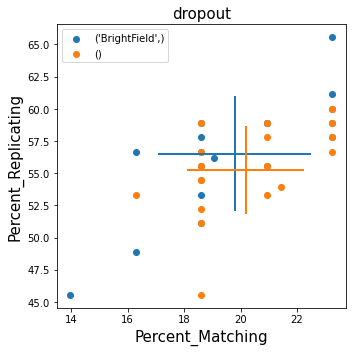

In [14]:
# 2

import matplotlib.pyplot as plt

group = "dropout"

df_subset = drop_df[
    (drop_df["sphering"] == True) &
    # Drop runs on all profiles, including those that don't even have an RNA channel
    # (not ideal, but saves time re-running)
    (drop_df["channel_names"].str.contains("BrightField"))
    ]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

utilssphering.group_plot(
    df=group_df, 
    x="Mean_Percent_Matching", 
    y="Mean_Percent_Replicating",
    group=group,
    error_x="SD_Percent_Matching",
    error_y="SD_Percent_Replicating",
    fig=fig,
    ax_=ax
)
utilssphering.group_plot(
    df_subset, 
    "Percent_Matching", 
    "Percent_Replicating", 
    group=group, 
    fig=fig, 
    ax_=ax, 
    legend=True)